# Add Folders to Path

In [4]:
%%time
import sys, os
# get current directory
path = os.getcwd()
# get parent directory
parent_directory = os.path.sep.join(path.split(os.path.sep)[:-2])
# add Algorithm folder to current working path in order to access the functions inside the folder ´Algorithms´
sys.path.append(parent_directory+"/Algorithm")

CPU times: user 257 µs, sys: 206 µs, total: 463 µs
Wall time: 327 µs


# Bickley

## Bickley Data

In [5]:
%%time
import scipy.io as sio

#Import velocity data from file in data-folder
mat_file = sio.loadmat('../../Data/Bickley.mat')

U = mat_file['u']
V = mat_file['v']
x = mat_file['x']
y = mat_file['y']
time = mat_file['t']

CPU times: user 3.25 ms, sys: 4.75 ms, total: 8 ms
Wall time: 8.13 ms


## Data/Parameters for Dynamical System

In [6]:
import numpy as np

# Number of cores to be used for parallel computing
Ncores = 16

# Incompressible/Compressible flow. {True, False}
Incompressible = True

# Periodic boundary conditions
periodic_x = False
periodic_y = False
Periodic = [periodic_x, periodic_y]

## Compute Meshgrid
X, Y = np.meshgrid(x, y)

# List of parameters of the flow.
params_data = {"X": X, "Y": Y, "Time": time, "U": U, "V": V, "Ncores": Ncores, 
               "Incompressible": Incompressible, "Periodic": Periodic}

<a id='Spatio-Temporal-Domain-of-Dynamical-System'></a>
## Spatio-Temporal Domain of Dynamical System

In [7]:
%%time

Ly = 1.77*10**6
Lx = 2*10**7
U = 62.66

# Initial time (in days)
t0 = 0

# Final time (in days)
tN = 4*Lx/U

# time step-size
dt = .1

time = np.arange(t0, tN+dt, dt)

# longitudinal and latitudinal boundaries (in degrees)
xmin = 0
xmax = Lx
ymin = -2.25*Ly
ymax = 2.25*Ly

# spacing of meshgrid (in degrees)
dx = (xmax-xmin)/500
dy = (ymax-ymin)/276

x_domain = np.arange(xmin, xmax + dx, dx)
y_domain = np.arange(ymin, ymax + dy, dy)

X_domain, Y_domain = np.meshgrid(x_domain, y_domain)

params_DS = {"time": time, "X_domain": X_domain, "Y_domain": Y_domain}

CPU times: user 36.8 ms, sys: 40.8 ms, total: 77.6 ms
Wall time: 75.5 ms


In [5]:
# Initialize Dynamical System
from ipynb.fs.defs.Dynamical_System import *
DS = Dynamical_System(params_data, params_DS)

## Velocity Interpolation

In [6]:
%%time
# Interpolate velocity data using cubic spatial interpolation
DS._Interpolation_velocity("cubic")

CPU times: user 80.6 ms, sys: 23.7 ms, total: 104 ms
Wall time: 132 ms


## Trajectory/Velocity  Computation

Trajectories are launched from the grid of initial conditions specified in [Section 2.3](#Spatio-Temporal-Domain-of-Dynamical-System) **(Line 14-17)**.

The temporal domain as well as the time resolution is also specified in [Section 2.3](#Spatio-Temporal-Domain-of-Dynamical-System) **(Line 2-11)**.

In [7]:
trajectory_grid, velocity_grid = DS._trajectory_grid();

  0%|          | 0/52 [00:00<?, ?it/s]

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   42.1s
[Parallel(n_jobs=16)]: Done  52 out of  52 | elapsed:  1.2min finished


## Gradient of Flow map

Trajectories are launched from the grid of initial conditions specified in [Section 2.3](#Spatio-Temporal-Domain-of-Dynamical-System) **(Line 14-17)**.

The temporal domain is specified in [Section 2.3](#Spatio-Temporal-Domain-of-Dynamical-System) **(Line 2-11)**.

In [8]:
# Auxiliary grid or adjacent
# trajectories for computation of gradients
# {True, False}
aux_grid = True

# Adaptive or fixed step size for 
# integration of trajectories
# {True, False}
adaptive = True

# tolerance bounds controlling accuracy 
# of adaptive step-size integration
tol_max = .01
tol_min = .001

grad_Fmap_grid = DS._grad_Fmap_grid(aux_grid, adaptive, tol_max, tol_min)

  0%|          | 0/52 [00:00<?, ?it/s]

## Cauchy-Green strain tensor over Meshgrid of Initial Conditions

In [9]:
B, C = DS._cauchy_green_strain(grad_Fmap_grid)

## Identify Vortex centers from local maximum of LAVD (PRA)

### LAVD-field

In [10]:
LAVD = DS._LAVD(trajectory_grid)

  0%|          | 0/201 [00:00<?, ?it/s]

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   35.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:  3.1min
[Parallel(n_jobs=16)]: Done 201 out of 201 | elapsed:  3.5min finished


In [11]:
# distance between local maxima
max_distance = 1.5

x_center, y_center, _ = DS._find_2D_peaks(max_distance, X_domain, Y_domain, LAVD)

  0%|          | 0/48 [00:00<?, ?it/s]

## Shearlines

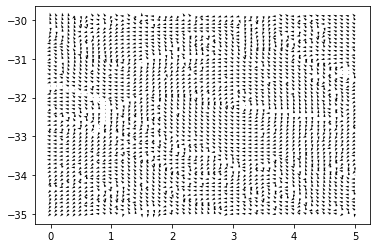

UnboundLocalError: local variable 'xc' referenced before assignment

In [12]:
step_size = 0.1
DS._elliptic_LCS_local_variational_theory(C, x_center, y_center, step_size, len_poincare = 3)

In [ ]:
print(DS.vector_field)

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (10, 6))
ax = plt.axes()
ax.contourf(X_domain, Y_domain, LAVD, levels=600)
ax.scatter(x_center, y_center)
plt.show()